In [ ]:
import tensorflow as tf
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is NOT available.")

GPU is available.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch.nn as nn
import torch.optim as optim
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer



In [ ]:
# Define paths
train_dir = '/content/drive/MyDrive/AgriculturalPests/dataset/train/'

In [ ]:


# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 for CvT model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])


# Load dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)


# Define data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
total_images = len(train_dataset)
print(f"Total number of images in train dataset: {total_images}")

Total number of images in train dataset: 2100


In [ ]:
(train_dataset.classes)

['ants',
 'earthworms',
 'earwig',
 'grasshopper',
 'moth',
 'snail',
 'wasp',
 'weevil']

In [ ]:
model_name = "microsoft/beit-base-patch16-224"
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=12,  # Your number of classes (e.g., ['Mild', 'Moderate', 'No', 'VeryMild'])
    ignore_mismatched_sizes=True
)
num_classes = 12  # Number of classes in your dataset
model.classifier = nn.Linear(model.classifier.in_features, num_classes)  # Correct modification


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([12]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_classes

12

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize lists to store loss and accuracy
los = []
train_accuracy = []

# Set the number of epochs
epc = 6

# Training loop
model.train()  # Set model to training mode
for epoch in range(epc):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, preds = torch.max(outputs.logits, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_accuracy = correct_predictions / total_samples

    # Print loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{epc}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Append loss and accuracy to the lists
    los.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)


Epoch 1/6, Loss: 0.9970, Accuracy: 0.6476
Epoch 2/6, Loss: 0.1742, Accuracy: 0.9433
Epoch 3/6, Loss: 0.0674, Accuracy: 0.9776
Epoch 4/6, Loss: 0.0294, Accuracy: 0.9919
Epoch 5/6, Loss: 0.0261, Accuracy: 0.9919
Epoch 6/6, Loss: 0.0090, Accuracy: 0.9986


In [ ]:
# Save entire model
#torch.save(model, "/content/drive/MyDrive/Alzheimers/output/beit_model.pth")

# Save only model weights
#torch.save(model.state_dict(), "/content/drive/MyDrive/Alzheimers/output/transformer_model_weights.pth")

torch.save(model.state_dict(), '/content/drive/MyDrive/AgriculturalPests/AgriculturalPests_beit_model.pth')

print(f"Model saved successfully at")

Model saved successfully at


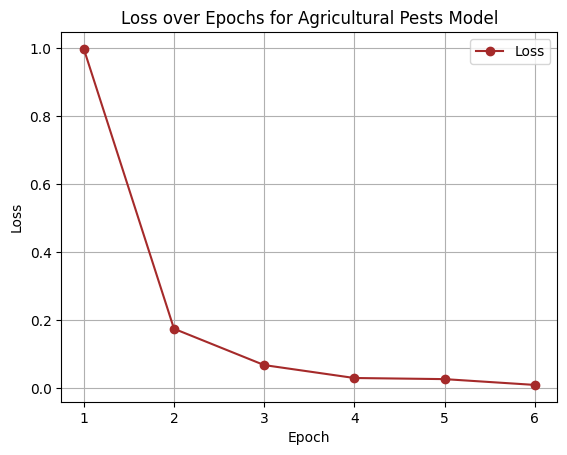

In [ ]:
import matplotlib.pyplot as plt


# Number of epochs
epochs = list(range(1, len(los) + 1))

# Plot the loss values
plt.plot(epochs, los, marker='o', linestyle='-', color='brown', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs for Agricultural Pests Model')
plt.legend()
plt.grid(True)
plt.show()

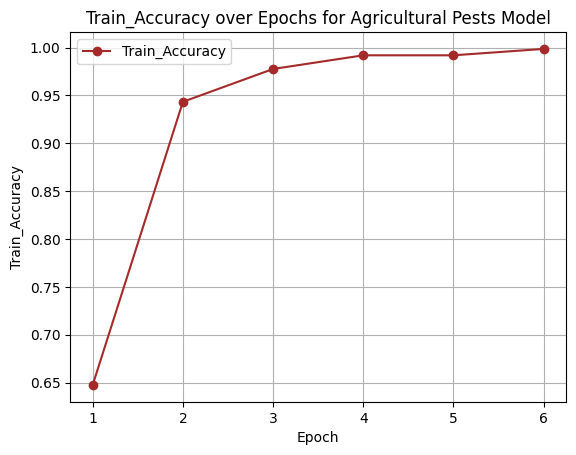

In [ ]:
import matplotlib.pyplot as plt


# Number of epochs
epochs = list(range(1, len(train_accuracy) + 1))

# Plot the loss values
plt.plot(epochs, train_accuracy, marker='o', linestyle='-', color='brown', label='Train_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Train_Accuracy')
plt.title('Train_Accuracy over Epochs for Agricultural Pests Model')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_dir = '/content/drive/MyDrive/AgriculturalPests/dataset/test/'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
total_images = len(test_dataset)
print(f"Total number of images in test dataset: {total_images}")

Total number of images in test dataset: 1653


In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

class_names = test_dataset.classes
actual = []
predicted = []
imageName = []
conf = []


# Function to display an image along with its labels
def show_image(img, actual_label, predicted_label, confidence, idx):
    img = img.permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and permute dimensions

    # Create a figure with high resolution but small size
    plt.figure(figsize=(2, 2), dpi=200)  # Small figure size with high dpi for clarity
    plt.imshow(img)
    plt.xlabel('X-axis (Pixels)')
    plt.ylabel('Y-axis (Pixels)')
    plt.title(f"Image {idx}\nActual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}", fontsize=8)
    plt.axis('off')
    plt.show()

j = 1
for images, labels in test_dataloader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)

    predicted_labels = torch.argmax(outputs.logits, dim=1)

    # Map predicted labels to class names
    predicted_class_names = [class_names[label] for label in predicted_labels]
    predicted_probs = F.softmax(outputs.logits, dim=1)
    confidences = torch.max(predicted_probs, dim=1).values

    # Convert actual labels to class names
    actual_class_names = [class_names[label] for label in labels.tolist()]

    for i in range(len(images)):
        print(j)
        print("Actual label:", actual_class_names[i])
        actual.append(actual_class_names[i])
        print("Predicted label:", predicted_class_names[i])
        predicted.append(predicted_class_names[i])
        imageName.append(j)
        print("Confidence:", confidences[i].item())
        conf.append(confidences[i].item())

        # Display the image with labels and confidence
        if(predicted_class_names[i] != actual_class_names[i]):
            show_image(images[i], actual_class_names[i], predicted_class_names[i], confidences[i].item(), j)
        else:
            print("True Prediction")


        j += 1


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, predicted)

In [ ]:
cm

array([[176,   1,  10,   6,   1,   0,   3,   2],
       [  3, 107,  10,  11,   5,   1,   0,   6],
       [  5,  10, 157,  15,   2,   0,   6,   1],
       [  2,   6,  15, 207,   0,   3,   0,   2],
       [  0,   0,   1,   6, 209,   0,   1,   0],
       [  1,   2,   4,   1,   0, 222,   0,   0],
       [  4,   0,   3,  10,   0,   0, 211,   0],
       [  6,   1,   2,   3,   0,   0,   0, 193]])

In [ ]:
from sklearn.metrics import classification_report


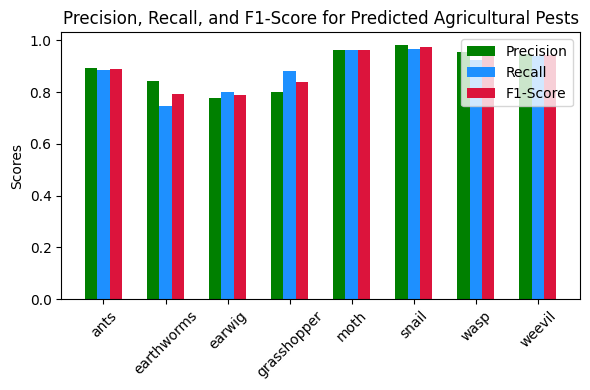

In [ ]:
#target_names=['Mild', 'Moderate', 'No', 'VeryMild']
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Define class labels
alzheimer_classes = ['ants',
 'earthworms',
 'earwig',
 'grasshopper',
 'moth',
 'snail',
 'wasp',
 'weevil']

# Generate classification report
rpt = classification_report(actual, predicted, target_names=alzheimer_classes, output_dict=True)

# Extract precision, recall, and f1-score for each class
precision = [rpt[label]['precision'] for label in alzheimer_classes]
recall = [rpt[label]['recall'] for label in alzheimer_classes]
f1_score = [rpt[label]['f1-score'] for label in alzheimer_classes]

# Set up bar positions and width
x = np.arange(len(alzheimer_classes))
width = 0.2  # Width of bars

# Plotting precision, recall, and f1-score
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x - width, precision, width, label='Precision', color='green')
ax.bar(x, recall, width, label='Recall', color='dodgerblue')
ax.bar(x + width, f1_score, width, label='F1-Score', color='crimson')

# Add labels, title, and custom ticks
#ax.set_xlabel('Alzheimer-Impairment Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for Predicted Agricultural Pests')
ax.set_xticks(x)
ax.set_xticklabels(alzheimer_classes)
ax.set_xticklabels(alzheimer_classes, rotation=45)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

        ants       0.89      0.88      0.89       199
  earthworms       0.84      0.75      0.79       143
      earwig       0.78      0.80      0.79       196
 grasshopper       0.80      0.88      0.84       235
        moth       0.96      0.96      0.96       217
       snail       0.98      0.97      0.97       230
        wasp       0.95      0.93      0.94       228
      weevil       0.95      0.94      0.94       205

    accuracy                           0.90      1653
   macro avg       0.89      0.89      0.89      1653
weighted avg       0.90      0.90      0.90      1653



In [ ]:
print(predicted)

['ants', 'ants', 'ants', 'earwig', 'earwig', 'ants', 'ants', 'earwig', 'ants', 'ants', 'ants', 'ants', 'grasshopper', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'earwig', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'wasp', 'ants', 'ants', 'ants', 'ants', 'ants', 'grasshopper', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'wasp', 'ants', 'ants', 'ants', 'ants', 'grasshopper', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'wasp', 'ants', 'ants', 'ants', 'earwig', 'ants', 'ants', 'ants', 'ants', 

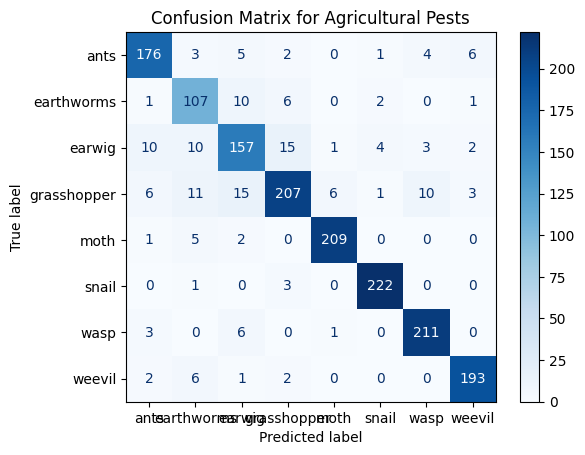

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert lists to numpy arrays
npredicted_classes = np.array(actual)
nactual_classes = np.array(predicted)

# Get unique class names from actual_classes
class_names = np.unique(actual)

# Compute confusion matrix
cm = confusion_matrix(nactual_classes, npredicted_classes, labels=class_names)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # Use 'd' to display integer values
plt.title('Confusion Matrix for Agricultural Pests')
plt.show()


Confusion Matrix:
 [[176   1  10   6   1   0   3   2]
 [  3 107  10  11   5   1   0   6]
 [  5  10 157  15   2   0   6   1]
 [  2   6  15 207   0   3   0   2]
 [  0   0   1   6 209   0   1   0]
 [  1   2   4   1   0 222   0   0]
 [  4   0   3  10   0   0 211   0]
 [  6   1   2   3   0   0   0 193]]


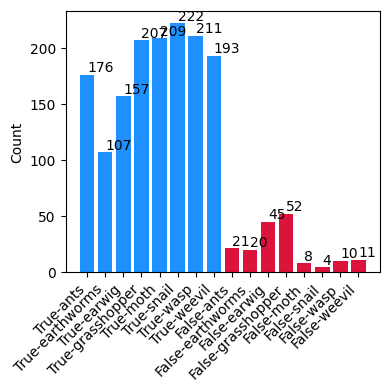

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assume test_true and test_preds are the true labels and predicted labels respectively
# Define class names based on the labels present in test_true and test_preds
class_names = np.unique(np.concatenate((actual, predicted)))

# Compute confusion matrix
cm = confusion_matrix(actual, predicted, labels=class_names)
print("Confusion Matrix:\n", cm)

# Extract counts from confusion matrix
true_positives = np.diag(cm)
false_positives = cm.sum(axis=0) - true_positives
false_negatives = cm.sum(axis=1) - true_positives

# Prepare data for bar graph
labels = [f'True-{cls}' for cls in class_names] + [f'False-{cls}' for cls in class_names]
counts = list(true_positives) + list(false_positives)

# Plot bar graph
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, counts, color=['dodgerblue']*len(class_names) + ['crimson']*len(class_names))
#plt.title('Counts of True and False Predictions Alzheimers-Impairments')
#plt.xlabel('Prediction Type')
plt.ylabel('Count')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('prediction_counts.png')
plt.show()

In [ ]:
import numpy as np

# Define the mapping
target_names=['ants',
 'earthworms',
 'earwig',
 'grasshopper',
 'moth',
 'snail',
 'wasp',
 'weevil']
label_mapping = {'ants':0,
 'earthworms':1,
 'earwig':2,
 'grasshopper':3,
 'moth':4,
 'snail':5,
 'wasp':6,
 'weevil':7}
nactual = np.array([label_mapping[label] for label in actual])
npredicted = np.array([label_mapping[label] for label in predicted])

In [ ]:
npredicted

array([0, 0, 0, ..., 7, 7, 7])

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Convert lists to numpy arrays
nnactual_classes = np.array(nactual)
nnpredicted_classes = np.array(npredicted)

# Compute Mean Absolute Error
mae = mean_absolute_error(nnactual_classes, nnpredicted_classes)

print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.2740


In [ ]:
import numpy as np
from sklearn.metrics import matthews_corrcoef



# Compute Matthews Correlation Coefficient
mcc = matthews_corrcoef(actual, predicted)

print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


Matthews Correlation Coefficient (MCC): 0.8816


In [ ]:
#5. ROC AUC Score
#The ROC AUC Score measures the area under the ROC curve, providing an aggregate measure of performance across all classification thresholds.
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(actual, predicted)
print(f"ROC AUC Score: {roc_auc:.4f}")


ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.

In [ ]:
#6. Cohen’s Kappa
#ECohen’s Kappa measures the agreement between observed and predicted classifications while accounting for chance.
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(actual, predicted)
print(f"Cohen’s Kappa: {kappa:.4f}")


Cohen’s Kappa: 0.8814


In [ ]:
#9. Hamming Loss
#Hamming Loss measures the fraction of labels that are incorrectly predicted.
from sklearn.metrics import hamming_loss

hamming = hamming_loss(actual, predicted)
print(f"Hamming Loss: {hamming:.4f}")


Hamming Loss: 0.1034


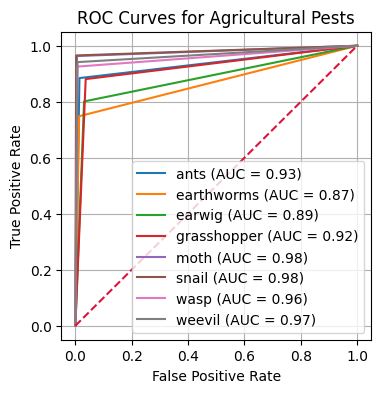

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Define class names
class_names = ['ants',
 'earthworms',
 'earwig',
 'grasshopper',
 'moth',
 'snail',
 'wasp',
 'weevil']

# Convert actual and predicted labels to binary format
actual_bin = label_binarize(actual, classes=class_names)
predicted_bin = label_binarize(predicted, classes=class_names)

# Initialize plot
plt.figure(figsize=(4, 4))

# Loop over each class to calculate ROC curve
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(actual_bin[:, i], predicted_bin[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot each class's ROC curve
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Plot diagonal line (random chance)
plt.plot([0, 1], [0, 1], linestyle='--', color='crimson')

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Agricultural Pests")
plt.legend(loc="lower right")
plt.grid()

# Show plot
plt.show()


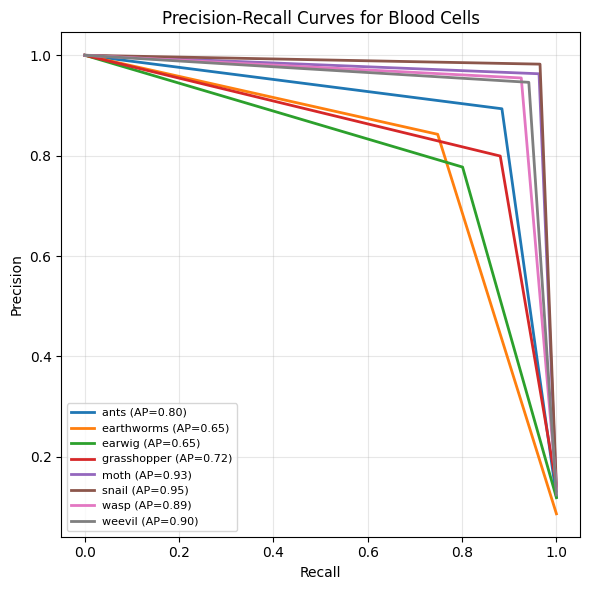

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize actual labels
actual_bin = label_binarize(actual, classes=class_names)

# Use probabilities if you have them;
# if you only have predicted labels, you can binarize as below (less ideal)
predicted_bin = label_binarize(predicted, classes=class_names)

# Initialize plot
plt.figure(figsize=(6, 6))

# Loop over each class to calculate Precision-Recall
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(actual_bin[:, i], predicted_bin[:, i])

    # Compute average precision for this class
    ap = average_precision_score(actual_bin[:, i], predicted_bin[:, i])

    plt.plot(recall, precision, linewidth=2, label=f"{class_name} (AP={ap:.2f})")

# Labels, title, legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Blood Cells")
plt.legend(fontsize=8, loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


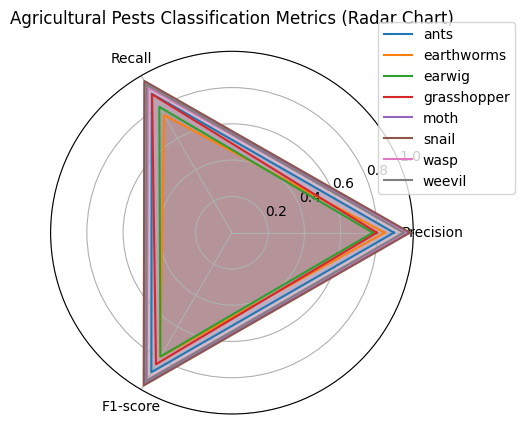

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Metrics
metrics = ['Precision', 'Recall', 'F1-score']
num_metrics = len(metrics)

# Pest classes
class_names = [
    'ants', 'earthworms', 'earwig', 'grasshopper',
    'moth', 'snail', 'wasp', 'weevil'
]

# Build scores dictionary from classification report
scores = {
    cls: [
        rpt[cls]['precision'],
        rpt[cls]['recall'],
        rpt[cls]['f1-score']
    ]
    for cls in class_names
}

# Create radar chart
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

# Angles for each metric
angles = np.linspace(0, 2 * pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the radar

# Plot each pest class
for class_name, values in scores.items():
    values = values + values[:1]  # close loop
    ax.plot(angles, values, linewidth=1.5, label=class_name)
    ax.fill(angles, values, alpha=0.15)

# Axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylim(0, 1)

# Title & legend
plt.title("Agricultural Pests Classification Metrics (Radar Chart)", pad=20)
plt.legend(bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


In [ ]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9df8204bda07fd0e4f5e92fb0ca3e5a1a604f11ea4d9538fa6d1682396641f8c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
test_dirs = {
    cls: f"/content/drive/MyDrive/AgriculturalPests/dataset/test/{cls}"
    for cls in class_names
}


In [ ]:
import os
imageNam = []
test_images = []

for label, path in test_dirs.items():
    if not os.path.exists(path):
        print(f"Warning: {path} does not exist")
        continue

    images = sorted(os.listdir(path))[:4]  # pick first 4 images

    for img_name in images:
        test_images.append((label, os.path.join(path, img_name)))
        imageNam.append(img_name)


In [ ]:
test_images

[('ants',
  '/content/drive/MyDrive/AgriculturalPests/dataset/test/ants/ants (300).jpg'),
 ('ants',
  '/content/drive/MyDrive/AgriculturalPests/dataset/test/ants/ants (301).jpg'),
 ('ants',
  '/content/drive/MyDrive/AgriculturalPests/dataset/test/ants/ants (302).jpg'),
 ('ants',
  '/content/drive/MyDrive/AgriculturalPests/dataset/test/ants/ants (303).jpg'),
 ('earthworms',
  '/content/drive/MyDrive/AgriculturalPests/dataset/test/earthworms/earthworms (181).jpg'),
 ('earthworms',
  '/content/drive/MyDrive/AgriculturalPests/dataset/test/earthworms/earthworms (182).jpg'),
 ('earthworms',
  '/content/drive/MyDrive/AgriculturalPests/dataset/test/earthworms/earthworms (183).jpg'),
 ('earthworms',
  '/content/drive/MyDrive/AgriculturalPests/dataset/test/earthworms/earthworms (184).jpg'),
 ('earwig',
  '/content/drive/MyDrive/AgriculturalPests/dataset/test/earwig/earwig (271).jpg'),
 ('earwig',
  '/content/drive/MyDrive/AgriculturalPests/dataset/test/earwig/earwig (272).jpg'),
 ('earwig',
  '/

In [ ]:
# ✅ LIME prediction function
def lime_predict(images):
    batch = torch.stack([transform(Image.fromarray(img)).to(device) for img in images])
    with torch.no_grad():
        preds = model(batch).logits
        return torch.softmax(preds, dim=1).cpu().numpy()


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
explainer = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

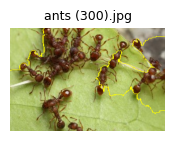

  0%|          | 0/1000 [00:00<?, ?it/s]

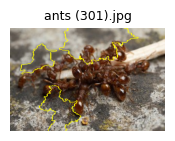

  0%|          | 0/1000 [00:00<?, ?it/s]

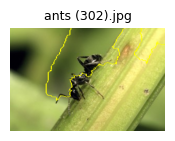

  0%|          | 0/1000 [00:00<?, ?it/s]

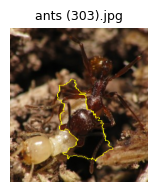

  0%|          | 0/1000 [00:00<?, ?it/s]

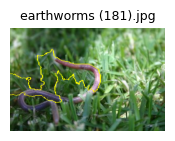

  0%|          | 0/1000 [00:00<?, ?it/s]

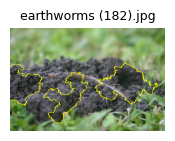

  0%|          | 0/1000 [00:00<?, ?it/s]

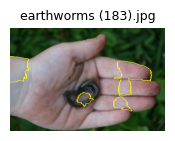

  0%|          | 0/1000 [00:00<?, ?it/s]

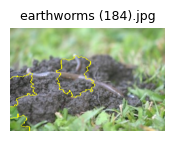

  0%|          | 0/1000 [00:00<?, ?it/s]

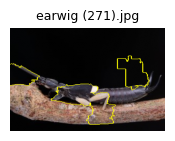

  0%|          | 0/1000 [00:00<?, ?it/s]

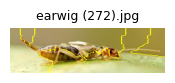

  0%|          | 0/1000 [00:00<?, ?it/s]

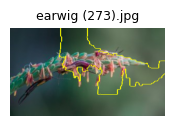

  0%|          | 0/1000 [00:00<?, ?it/s]

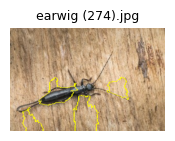

  0%|          | 0/1000 [00:00<?, ?it/s]

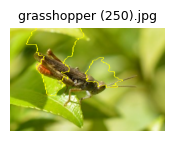

  0%|          | 0/1000 [00:00<?, ?it/s]

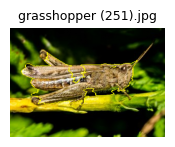

  0%|          | 0/1000 [00:00<?, ?it/s]

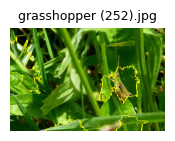

  0%|          | 0/1000 [00:00<?, ?it/s]

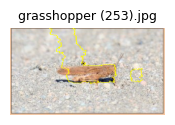

  0%|          | 0/1000 [00:00<?, ?it/s]

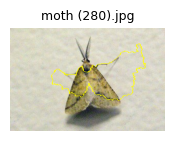

  0%|          | 0/1000 [00:00<?, ?it/s]

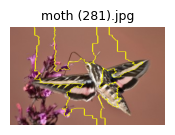

  0%|          | 0/1000 [00:00<?, ?it/s]

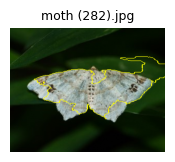

  0%|          | 0/1000 [00:00<?, ?it/s]

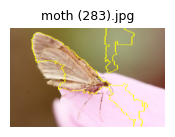

  0%|          | 0/1000 [00:00<?, ?it/s]

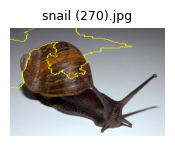

  0%|          | 0/1000 [00:00<?, ?it/s]

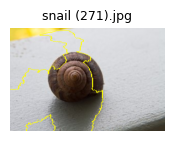

  0%|          | 0/1000 [00:00<?, ?it/s]

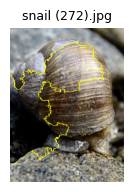

  0%|          | 0/1000 [00:00<?, ?it/s]

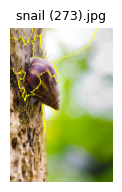

  0%|          | 0/1000 [00:00<?, ?it/s]

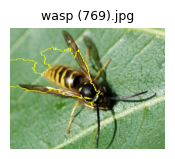

  0%|          | 0/1000 [00:00<?, ?it/s]

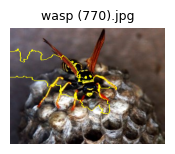

  0%|          | 0/1000 [00:00<?, ?it/s]

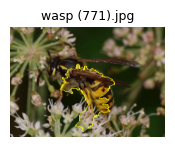

  0%|          | 0/1000 [00:00<?, ?it/s]

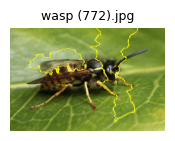

  0%|          | 0/1000 [00:00<?, ?it/s]

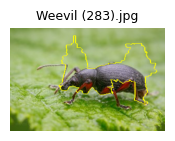

  0%|          | 0/1000 [00:00<?, ?it/s]

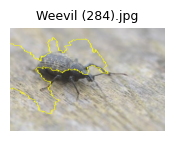

  0%|          | 0/1000 [00:00<?, ?it/s]

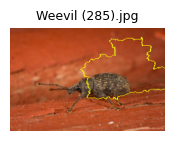

  0%|          | 0/1000 [00:00<?, ?it/s]

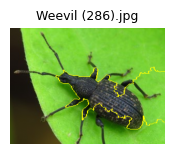

In [ ]:
# ✅ Initialize LIME Explainer


# ✅ Process each image
i=0
for idx, (label, image_path) in enumerate(test_images):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")

    # Generate LIME explanation
    explanation = explainer.explain_instance(
        np.array(image),
        lime_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get the predicted class
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor).logits
        predicted_class = torch.argmax(torch.softmax(output, dim=1)).item()

    # ✅ Visualize Explanation
    temp, mask = explanation.get_image_and_mask(predicted_class, positive_only=True, num_features=5, hide_rest=False)

    plt.figure(figsize=(2, 2))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"{imageNam[i]}", fontsize=9)
    #plt.title(f"LIME Explanation")

    plt.axis("off")
    plt.show()
    i=i+1

In [ ]:
imageNam

['ants (300).jpg',
 'ants (301).jpg',
 'ants (302).jpg',
 'ants (303).jpg',
 'earthworms (181).jpg',
 'earthworms (182).jpg',
 'earthworms (183).jpg',
 'earthworms (184).jpg',
 'earwig (271).jpg',
 'earwig (272).jpg',
 'earwig (273).jpg',
 'earwig (274).jpg',
 'grasshopper (250).jpg',
 'grasshopper (251).jpg',
 'grasshopper (252).jpg',
 'grasshopper (253).jpg',
 'moth (280).jpg',
 'moth (281).jpg',
 'moth (282).jpg',
 'moth (283).jpg',
 'snail (270).jpg',
 'snail (271).jpg',
 'snail (272).jpg',
 'snail (273).jpg',
 'wasp (769).jpg',
 'wasp (770).jpg',
 'wasp (771).jpg',
 'wasp (772).jpg',
 'Weevil (283).jpg',
 'Weevil (284).jpg',
 'Weevil (285).jpg',
 'Weevil (286).jpg']

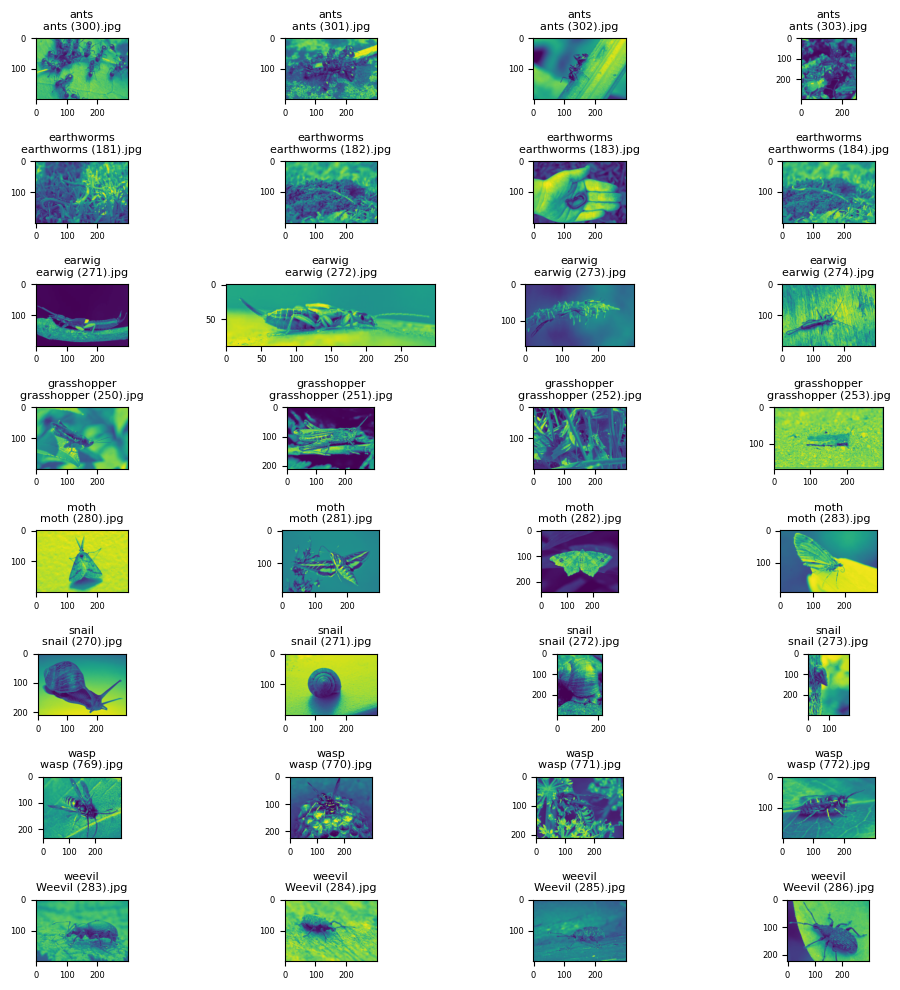

In [ ]:
#Train Images
import os
import matplotlib.pyplot as plt
from PIL import Image





# ✅ Plot Images in Grid (3 Rows: Mild, Moderate, No; 4 Columns)
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(10, 10))  # 3 rows, 4 columns

for i, (label, img_path) in enumerate(test_images):
    row = i // 4  # Determine row index
    col = i % 4   # Determine column index

    image = Image.open(img_path).convert("L")  # Convert to grayscale (L mode)

    # ✅ Display Image with Grayscale Fix
    axes[row, col].imshow(image)  # Force black & white
    axes[row, col].set_title(f"{label}\n{imageNam[i]}", fontsize=8)  # Display class & filename
    #axes[row, col].set_xlabel("Width (px)", fontsize=6)  # X-axis label
    #axes[row, col].set_ylabel("Height (px)", fontsize=6) # Y-axis label
    axes[row, col].tick_params(axis='both', which='both', labelsize=6)  # Reduce tick font size

plt.tight_layout()
plt.show()
